In [1]:
import json
# import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import pickle
from constants import *
import rioxarray as rxr
from pyproj import crs

homedir = '/global/home/users/cowherd/snow_fires/'
datadir = '/global/scratch/users/cowherd/'

os.chdir(homedir)

wgs_crs = crs.CRS('epsg:4326')
use_crs = wgs_crs

from load_data import *
## gives fires_allyears, wfigs20, gages_metadata, bas_all, gaged_basins_gdf, snowzone
## all in wgs crs


In [105]:
bas_all = bas_all.set_crs(bas_ref.crs)
bas_all = bas_all.to_crs(wgs_crs) # with wgs 84 CRS


In [106]:
len(bas_all)

9322

In [ ]:
# save to files
bas_all.to_file(datadir + 'bas_all.gdf')

/global/home/users/cowherd/.conda/envs/snow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
bas_all.plot()

In [96]:
#usgs reference basin boundaries
bas_ref = gpd.read_file('/global/scratch/users/cowherd/boundaries-shapefiles-by-aggeco/bas_ref_all.shp')
#usgs non-reference basin boundaries (entire US, multiple files by region)
bas_nonref_names = glob.glob(datadir + 'boundaries-shapefiles-by-aggeco/' + '*nonref*.shp')
bas_nonref=gpd.GeoDataFrame()
for f in bas_nonref_names:
    data = gpd.read_file(f)
    bas_nonref = pd.concat([bas_nonref,data])
    print(len(bas_nonref))
    # bas_nonref = bas_nonref.append(data)
bas_all = pd.concat([bas_nonref,bas_ref])
# bas_all = bas_nonref.append(bas_ref)
bas_all = bas_all.set_crs(bas_ref_all.crs)
bas_all = bas_ref_all.to_crs(wgs_crs) # with wgs 84 CRS

gages_metadata = gpd.GeoDataFrame()
gages_metadata['geometry'] = [Point(xy) for xy in zip(md.Longitude, md.Latitude)] 
gages_metadata['gage_id'] = [val for val in md.Gauge_ID]
gages_metadata['fire_year'] = [val for val in md.Fire_Year]
gages_metadata = gages_metadata.set_crs(wgs_crs)

# save to files
bas_all.to_file(datadir + 'bas_all.gdf')

NameError: name 'bas_ref_all' is not defined

In [3]:
names = ['East Branch N. Fork Feather',
         'Upper Mokelumne',
         'Upper Merced',
         'Upper Kaweah',
         'Upper Tule',
         'Upper Kern',
         'South Fork Kern'
        ]
gage_ids = [11402000,
            11318500,
            11266500,
            11208000,
            11202710,
            11185500,
            11189500
           ]
target_gages = pd.DataFrame({
    'name':names,
    'gage_id':gage_ids
})

In [18]:
allgages = gpd.read_file(datadir + 'gagesii/gagesII_9322_sept30_2011.shp')
## are all of them already in my metadata file from before?
pts = []
for i in range(len(target_gages)):
    g = target_gages['gage_id'][i]
    tmp = allgages[allgages['STAID']==str(g)]
    if len(tmp)==0:
        print('no ' + str(g))
        pts.append(np.nan)
    else:
        pts.append(tmp['geometry'].to_crs('epsg:4326'))

## did some copypasting to get beloew 

In [72]:
lats=[-120.95440,
-120.54548,
-119.66628,
-118.79927,
-118.70954,
-118.467586, 
-118.17369]
lons=[40.00295,
38.36825,
37.71687,
36.52189,
36.16134,
35.90550439,
35.73745]

points = [Point(xy) for xy in zip(lons,lats)]

In [78]:
data = {
    'gage_id':target_gages['gage_id'],
    'name':target_gages['name']}
target_gages = gpd.GeoDataFrame(data= data,geometry= points)

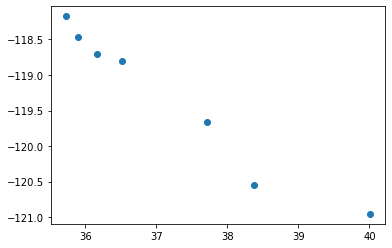

In [81]:
target_gages.plot()
plt.show()
## add in the contextily background some other time, package isn't going well rn

In [82]:
## function that gets the streamflow data from a given site
def get_details (site, start_date, end_date):
    url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)
    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data['site_num'] = site_num
    if site_num != site :
        good_data['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data['var_description'] = var_description

    # get datapoints
    good_data['series'] = []
    good_data['value'] = []
    good_data['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data['series'].append(item)
        good_data['value'].append(item['value'])
        good_data['datetime'].append(item['dateTime'])    
    return good_data

In [ ]:
ids = [str(val) for val in bas_all['GAGE_ID']]
gaged_basins = gpd.GeoDataFrame()
for i in range(len(target_gages)):
    g = str(target_gages['gage_id'][i])
    data = bas_all.loc[(bas_all['GAGE_ID']==g)]
    if len(data)==0: 
        print('no watershed '+ g )
    else: print('yes watershed ' + g)
    gaged_basins = pd.concat([gaged_basins, data])

with open(datadir + 'target_basins.pickle', 'wb') as handle:
    pickle.dump(gaged_basins, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
gaged_basins_gdf = gpd.GeoDataFrame(data = gaged_basins[['AREA','PERIMETER','GAGE_ID']],geometry = gaged_basins['geometry'])
gaged_basins_gdf.to_file(datadir + 'target_basins.gdf')

<AxesSubplot:>

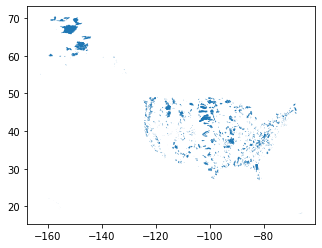

In [95]:
## get streamflow data
data = []
for i in range(len(target_basins)):
    site = target_basins['gage_id'][i]
    newdata = get_details(site = site, start_date = start_date,end_date=end_date)
    data = pd.concat(data,newdata)

In [ ]:
fp = '/global/scratch/users/cowherd/reanalysis/h5/'

#daily_swe = {}
#daily_swe_total = {}
#max_day = []
#max_swe = []
daily_swe_mean = {}
for yr in  [1986]: # range(1985 , 2016):
    hf = h5py.File(fp + 'SN_SWE_WY'+ str(yr) + '.h5', 'r')
    swe = hf.get('SWE')
    dailyswe = []
    numpixels = []
    for i in [180]: #range(365):
        swe_tmp = np.array(swe[i,:,:])
        swe_tmp=swe_tmp[swe_tmp>0]
        dailyswe.append(np.nanmean(swe_tmp))
        numpixels.append(len(swe_tmp))
    dailyswe=np.array(dailyswe)
    numpixels = np.array(numpixels)
    #maxswe = np.nanmax(dailyswe[numpixels>1e6])
    #maxday = np.where(dailyswe == maxswe)[0][0]
    daily_swe_mean[yr] = dailyswe
    #max_day.append(maxday)
    #max_swe.append(maxswe)